In [13]:
import MDAnalysis as mda 
import matplotlib.pyplot as plt

import clustering.cluster as psw_cluster

In [2]:
topology_ = '../../../for_hrach/tx114/production.tpr'

trajectory_ = '../../../for_hrach/tx114/production.trr'

u=mda.Universe(topology_,trajectory_)

micelle=u.select_atoms('not name HW? OW')


In [3]:
largest_cluster_resids=psw_cluster.find_largest_cluster(u,
                                   frame=10,
                                   selection='name C*',
                                   cutoff_distance=6,
                                   define_clustering_atoms=False)()
print(largest_cluster_resids)

[139, 141, 27, 30, 37, 49, 50, 52, 69, 70, 73, 78, 81, 84, 89, 99, 104, 114, 116, 120, 124, 125]


In [4]:
c=psw_cluster.find_all_clusters(u,
                                frame=10,
                                selection='name C*',
                                cutoff_distance=6,
                                define_clustering_atoms=False)()
print(c)

[[0, 19, 141], [1, 40, 105, 16, 116, 120], [2, 66, 5, 135, 41, 43, 111, 84, 85, 118, 95, 62, 127], [24, 57, 114, 3], [10, 4, 76], [32, 33, 132, 133, 6, 42, 20, 117, 86, 121, 28], [112, 7], [8], [129, 9, 12, 143, 144, 18, 23, 39, 45, 50, 54, 55, 61, 63, 65, 70, 81, 91, 92, 104, 110], [122, 11, 71, 47], [100, 13, 17, 89, 60], [14], [15], [21], [82, 75, 22], [34, 131, 44, 52, 25], [138, 140, 26, 29, 36, 48, 49, 51, 68, 69, 72, 77, 80, 83, 88, 98, 103, 113, 115, 119, 123, 124], [27], [96, 130, 37, 90, 30], [31], [35], [38], [46], [109, 53], [56], [58], [59], [64], [67], [73], [74], [78], [79], [87], [148, 93], [94], [136, 97], [99], [101, 134], [102], [106], [145, 107], [108], [125], [126], [128], [137], [139], [142], [146], [147], [149]]


In [9]:
micelle_shell= 'resname TX4 and not name C1D C1C C1B C1A C1E C1F C2 C3A C3B C4 C5 C6C C6B C6A '
micelle_core= 'resname TX4 and name C1D C1C C1B C1A C1E C1F C2 C3A C3B C4 C5 C6C C6B C6A '

results=psw_cluster.make_cluster_whole(u,
                                frame = 10,
                                cluster_resids  = largest_cluster_resids,
                                core_selection  = micelle_core,
                                shell_selection = micelle_shell)()

(array([14., 13., 32., 28., 46., 41., 62., 35., 17., 20.]),
 array([45.235893, 48.412716, 51.589535, 54.766357, 57.943176, 61.12    ,
        64.29682 , 67.47364 , 70.65046 , 73.827286, 77.004105],
       dtype=float32),
 <BarContainer object of 10 artists>)

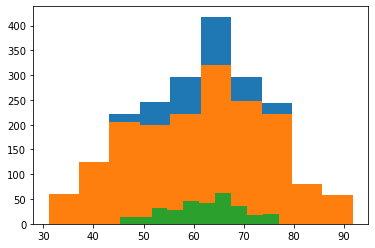

In [18]:
plt.hist(results[0][:,1])
plt.hist(results[2][:,1])
plt.hist(results[1][:,1])